## Spark environment

In [ ]:
!apt-get update > /dev/null #linux system update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null # installing Java 8

In [ ]:
!wget -q http://apache.osuosl.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop3.2.tgz # downloading Apache Spark

In [ ]:
!tar xf spark-3.0.1-bin-hadoop3.2.tgz #unzipping
!pip install -q findspark # using Findspark to locate the spark in the system

In [ ]:
ls

sample_data/  spark-3.0.1-bin-hadoop3.2/  spark-3.0.1-bin-hadoop3.2.tgz


In [ ]:
# set environment path for java and spark that enables us to run PySpark in Colab

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64" 
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init() #it will search spark and set it in system path

In [ ]:
# run a local spark session to test our installation

from pyspark.sql import SparkSession #to work in spark we need spark context
# note UI port switched from default 4040 to 4050 to avoid clash with ngrok
spark = SparkSession.builder.master("local[*]").config('spark.ui.port', '4050').getOrCreate() #spark instance, either create it or get and create

In [ ]:
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-shell>

Colab is ready to run PySpark.

## Getting data

In [ ]:
!wget -q https://raw.githubusercontent.com/hrisav/loan-eligibility/main/loan_acceptance_data.csv #Getting the file

In [ ]:
ls

loan_acceptance_data.csv  spark-3.0.1-bin-hadoop3.2/
sample_data/              spark-3.0.1-bin-hadoop3.2.tgz


In [ ]:
df=spark.read.csv('/content/loan_acceptance_data.csv',inferSchema=True,header=True)

In [ ]:
print((df.count(),len(df.columns)))

(614, 13)


In [ ]:
df.printSchema()

root
 |-- Loan_ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Married: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- Self_Employed: string (nullable = true)
 |-- ApplicantIncome: integer (nullable = true)
 |-- CoapplicantIncome: double (nullable = true)
 |-- LoanAmount: integer (nullable = true)
 |-- Loan_Amount_Term: integer (nullable = true)
 |-- Credit_History: integer (nullable = true)
 |-- Property_Area: string (nullable = true)
 |-- Loan_Status: string (nullable = true)



In [ ]:
df.show(5)

+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
| Loan_ID|Gender|Married|Dependents|   Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|
+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|LP001002|  Male|     No|         0|    Graduate|           No|           5849|              0.0|      null|             360|             1|        Urban|          Y|
|LP001003|  Male|    Yes|         1|    Graduate|           No|           4583|           1508.0|       128|             360|             1|        Rural|          N|
|LP001005|  Male|    Yes|         0|    Graduate|          Yes|           3000|              0.0|        66|             360|             1|        Urban|          Y

In [ ]:
df.dtypes

[('Loan_ID', 'string'),
 ('Gender', 'string'),
 ('Married', 'string'),
 ('Dependents', 'string'),
 ('Education', 'string'),
 ('Self_Employed', 'string'),
 ('ApplicantIncome', 'int'),
 ('CoapplicantIncome', 'double'),
 ('LoanAmount', 'int'),
 ('Loan_Amount_Term', 'int'),
 ('Credit_History', 'int'),
 ('Property_Area', 'string'),
 ('Loan_Status', 'string')]

In [ ]:
df.describe().show()

+-------+--------+------+-------+------------------+------------+-------------+-----------------+------------------+------------------+-----------------+------------------+-------------+-----------+
|summary| Loan_ID|Gender|Married|        Dependents|   Education|Self_Employed|  ApplicantIncome| CoapplicantIncome|        LoanAmount| Loan_Amount_Term|    Credit_History|Property_Area|Loan_Status|
+-------+--------+------+-------+------------------+------------+-------------+-----------------+------------------+------------------+-----------------+------------------+-------------+-----------+
|  count|     614|   601|    611|               599|         614|          582|              614|               614|               592|              600|               564|          614|        614|
|   mean|    null|  null|   null|0.5547445255474452|        null|         null|5403.459283387622| 1621.245798027101|146.41216216216216|            342.0|0.8421985815602837|         null|       null|
| std

In [ ]:
df = df.drop(*['Loan_ID'])
df.show(5)

+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|Gender|Married|Dependents|   Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|
+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|  Male|     No|         0|    Graduate|           No|           5849|              0.0|      null|             360|             1|        Urban|          Y|
|  Male|    Yes|         1|    Graduate|           No|           4583|           1508.0|       128|             360|             1|        Rural|          N|
|  Male|    Yes|         0|    Graduate|          Yes|           3000|              0.0|        66|             360|             1|        Urban|          Y|
|  Male|    Yes|         0|Not Graduate|           N

## Handling Missing Values

In [ ]:
# null values in each column

from pyspark.sql.functions import col,sum

df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df.columns)).show()

+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|Gender|Married|Dependents|Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|
+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|    13|      3|        15|        0|           32|              0|                0|        22|              14|            50|            0|          0|
+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+



In [ ]:
from pyspark.sql.functions import mean

mean_val = df.select(mean(df.LoanAmount)).collect()

print('Mean value of Loan Amount', mean_val[0][0])

Mean value of Loan Amount 146.41216216216216


In [ ]:
mean_val

[Row(avg(LoanAmount)=146.41216216216216)]

In [ ]:
# using mean_loan_amount value to fill the nulls in LoanAmount column

mean_loan_amount = mean_val[0][0]

df = df.na.fill(mean_loan_amount, subset=['LoanAmount'])

mean_val = df.select(mean(df.LoanAmount)).collect()
print('New Mean value of Loan Amount', mean_val[0][0])

New Mean value of Loan Amount 146.3973941368078


In [ ]:
from pyspark.sql.functions import isnan, when, count, col

df.select([count(when(col('Loan_Amount_Term').isNull(),True)).alias('Loan_Amount_Term')]).show()

+----------------+
|Loan_Amount_Term|
+----------------+
|              14|
+----------------+



In [ ]:
median_loan_term = df.approxQuantile("Loan_Amount_Term", [0.5], 0.25)
median_loan_term = int(median_loan_term[0])

print('Median value of Loan_Amount_Term', median_loan_term)

Median value of Loan_Amount_Term 360


In [ ]:
# using median_loan_term value to fill the nulls in Loan_Amount_Term column

df = df.na.fill(median_loan_term, subset=['Loan_Amount_Term'])

df.select([count(when(col('Loan_Amount_Term').isNull(),True)).alias('Loan_Amount_Term')]).show()

+----------------+
|Loan_Amount_Term|
+----------------+
|               0|
+----------------+



In [ ]:
df.groupBy("Gender").count().show()

+------+-----+
|Gender|count|
+------+-----+
|  null|   13|
|Female|  112|
|  Male|  489|
+------+-----+



In [ ]:
df = df.na.fill('Male',subset=['Gender'])
df.groupBy("Gender").count().show()

+------+-----+
|Gender|count|
+------+-----+
|Female|  112|
|  Male|  502|
+------+-----+



In [ ]:
df.groupBy("Married").count().show()

+-------+-----+
|Married|count|
+-------+-----+
|   null|    3|
|     No|  213|
|    Yes|  398|
+-------+-----+



In [ ]:
df = df.na.fill('Yes',subset=['Married'])
df.groupBy("Married").count().show()

+-------+-----+
|Married|count|
+-------+-----+
|     No|  213|
|    Yes|  401|
+-------+-----+



In [ ]:
df.groupBy("Dependents").count().show()

+----------+-----+
|Dependents|count|
+----------+-----+
|         0|  345|
|      null|   15|
|         1|  102|
|        3+|   51|
|         2|  101|
+----------+-----+



In [ ]:
df = df.na.fill('0',subset=['Dependents'])
df.groupBy("Dependents").count().show()

+----------+-----+
|Dependents|count|
+----------+-----+
|         0|  360|
|         1|  102|
|        3+|   51|
|         2|  101|
+----------+-----+



In [ ]:
df.groupBy("Self_Employed").count().show()

+-------------+-----+
|Self_Employed|count|
+-------------+-----+
|         null|   32|
|           No|  500|
|          Yes|   82|
+-------------+-----+



In [ ]:
df = df.na.fill('No',subset=['Self_Employed'])
df.groupBy("Self_Employed").count().show()

+-------------+-----+
|Self_Employed|count|
+-------------+-----+
|           No|  532|
|          Yes|   82|
+-------------+-----+



In [ ]:
df.groupBy("Credit_History").count().show()

+--------------+-----+
|Credit_History|count|
+--------------+-----+
|          null|   50|
|             1|  475|
|             0|   89|
+--------------+-----+



In [ ]:
df = df.na.fill(1,subset=['Credit_History'])
df.groupBy("Credit_History").count().show()

+--------------+-----+
|Credit_History|count|
+--------------+-----+
|             1|  525|
|             0|   89|
+--------------+-----+



In [ ]:
df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df.columns)).show()

+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|Gender|Married|Dependents|Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|
+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|     0|      0|         0|        0|            0|              0|                0|         0|               0|             0|            0|          0|
+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+



## Exploratory Data Analysis

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Text(0.5, 1.0, 'Distribution of Applicant Income')

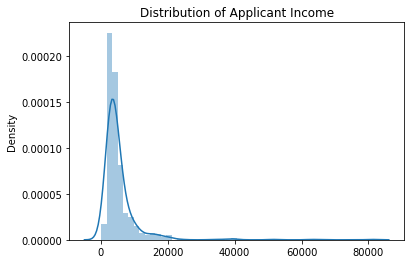

In [ ]:
# plotting ApplicantIncome

df_plot = df.select(['ApplicantIncome']).toPandas()
sns.distplot(df_plot)
plt.title('Distribution of Applicant Income')

Text(0.5, 1.0, 'Distribution of Coapplicant Income')

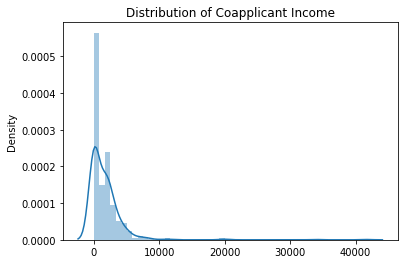

In [ ]:
# plotting CoapplicantIncome

df_plot = df.select(['CoapplicantIncome']).toPandas()
sns.distplot(df_plot)
plt.title('Distribution of Coapplicant Income')

Text(0.5, 1.0, 'Distribution of Loan Amount')

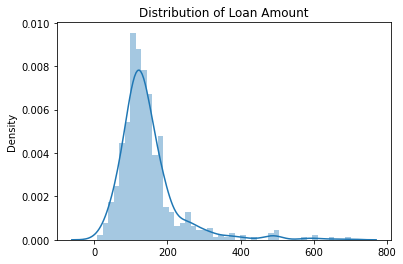

In [ ]:
# plotting LoanAmount

df_plot = df.select(['LoanAmount']).toPandas()
sns.distplot(df_plot)
plt.title('Distribution of Loan Amount')

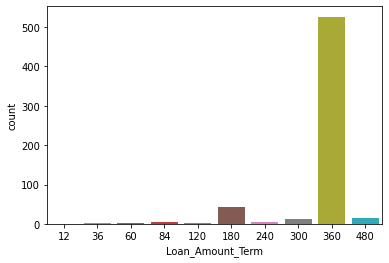

In [ ]:
# plotting Loan_Amount_Term

df_plot = df.select(['Loan_Amount_Term']).toPandas()
sns.countplot(df_plot['Loan_Amount_Term'])

In [ ]:
df.groupBy("Loan_Status").count().show()

+-----------+-----+
|Loan_Status|count|
+-----------+-----+
|          Y|  422|
|          N|  192|
+-----------+-----+



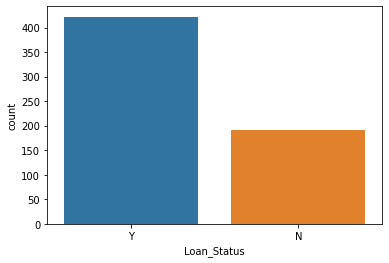

In [ ]:
# plotting Loan_Status

df_plot = df.select(['Loan_Status']).toPandas()
sns.countplot(df_plot['Loan_Status'])

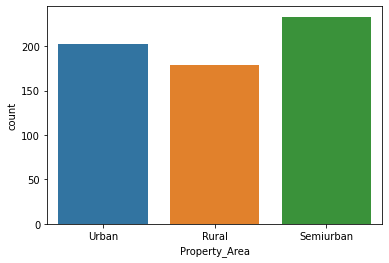

In [ ]:
# plotting Property_Area

df_plot = df.select(['Property_Area']).toPandas()
sns.countplot(df_plot['Property_Area'])

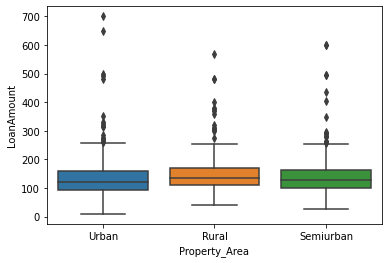

In [ ]:
df_plot = df.select(['Property_Area','LoanAmount']).toPandas()
sns.boxplot(df_plot['Property_Area'],df_plot['LoanAmount'])

Median Loan Amount provided to Rural Area is slightly higher than Urban. But there are some people in Urban who has got higher loan amounts compared to Rural or Semi urban.

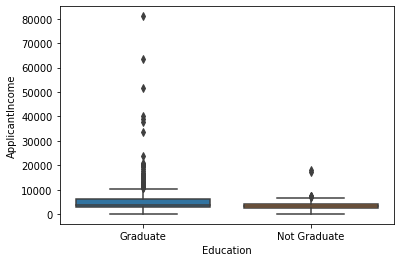

In [ ]:
df_plot = df.select(['Education','ApplicantIncome']).toPandas()
sns.boxplot(df_plot['Education'],df_plot['ApplicantIncome'])

Even though there is not much difference between the mean income of graduate and non-graduates, there are more number of Graduates with very high incomes compared to Not Graduates.

In [ ]:
df.groupBy("Gender").pivot("Loan_Status").count().show()

+------+---+---+
|Gender|  N|  Y|
+------+---+---+
|Female| 37| 75|
|  Male|155|347|
+------+---+---+



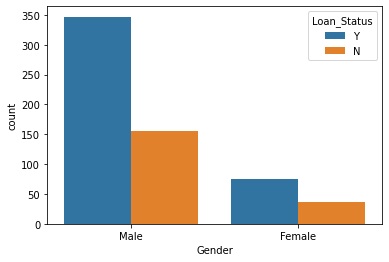

In [ ]:
df_plot = df.select(['Gender','Loan_Status']).toPandas()
sns.countplot(x=df_plot['Gender'],hue=df_plot['Loan_Status'])

Chances for getting Loan approved for Male or Female is almost equal.

In [ ]:
  df.groupBy("Married").pivot("Loan_Status").count().show()

+-------+---+---+
|Married|  N|  Y|
+-------+---+---+
|     No| 79|134|
|    Yes|113|288|
+-------+---+---+



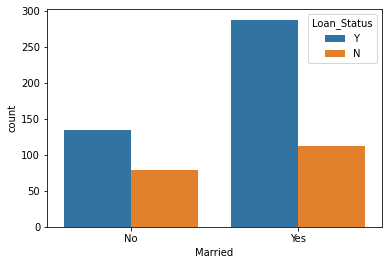

In [ ]:
df_plot = df.select(['Married','Loan_Status']).toPandas()
sns.countplot(x=df_plot['Married'],hue=df_plot['Loan_Status'])

Married people have higher chance of getting loan approved.

In [ ]:
df.groupBy("Dependents").pivot("Loan_Status").count().show()

+----------+---+---+
|Dependents|  N|  Y|
+----------+---+---+
|         0|113|247|
|         1| 36| 66|
|        3+| 18| 33|
|         2| 25| 76|
+----------+---+---+



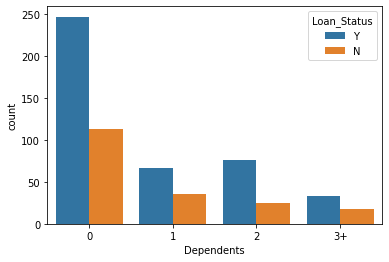

In [ ]:
df_plot = df.select(['Dependents','Loan_Status']).toPandas()
sns.countplot(x=df_plot['Dependents'],hue=df_plot['Loan_Status'])

When the number of dependents is 2 there is more chance of getting loan approval compared to when the number of dependents is 1, even though both has similar data count.

In [ ]:
  df.groupBy("Education").pivot("Loan_Status").count().show()

+------------+---+---+
|   Education|  N|  Y|
+------------+---+---+
|Not Graduate| 52| 82|
|    Graduate|140|340|
+------------+---+---+



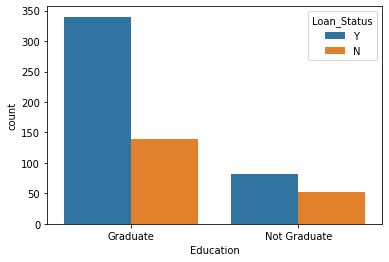

In [ ]:
df_plot = df.select(['Education','Loan_Status']).toPandas()
sns.countplot(x=df_plot['Education'],hue=df_plot['Loan_Status'])

Graduates have more chances of getting their loan approved.

In [ ]:
  df.groupBy("Credit_History").pivot("Loan_Status").count().show()

+--------------+---+---+
|Credit_History|  N|  Y|
+--------------+---+---+
|             1|110|415|
|             0| 82|  7|
+--------------+---+---+



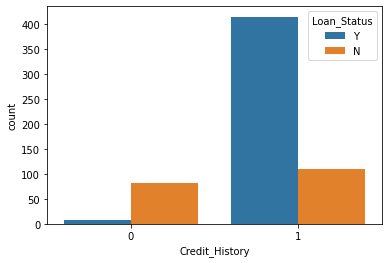

In [ ]:
df_plot = df.select(['Credit_History','Loan_Status']).toPandas()
sns.countplot(x=df_plot['Credit_History'],hue=df_plot['Loan_Status'])

There is very rare chance of getting loan if the person has no credit history.

In [ ]:
  df.groupBy("Property_Area").pivot("Loan_Status").count().show()

+-------------+---+---+
|Property_Area|  N|  Y|
+-------------+---+---+
|        Urban| 69|133|
|    Semiurban| 54|179|
|        Rural| 69|110|
+-------------+---+---+



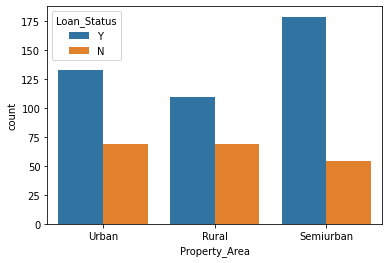

In [ ]:
df_plot = df.select(['Property_Area','Loan_Status']).toPandas()
sns.countplot(x=df_plot['Property_Area'],hue=df_plot['Loan_Status'])

Most of the person is from Semiurban area, and highest Loan acceptance is from that area.

## Feature Engineering

In [ ]:
from pyspark.sql.functions import col

df = df.withColumn("TotalIncome", col("ApplicantIncome")+col("CoapplicantIncome"))
df.show(5)

+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+-----------+
|Gender|Married|Dependents|   Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|TotalIncome|
+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+-----------+
|  Male|     No|         0|    Graduate|           No|           5849|              0.0|       146|             360|             1|        Urban|          Y|     5849.0|
|  Male|    Yes|         1|    Graduate|           No|           4583|           1508.0|       128|             360|             1|        Rural|          N|     6091.0|
|  Male|    Yes|         0|    Graduate|          Yes|           3000|              0.0|        66|             360|             1|        Urban|     

In [ ]:
df = df.withColumn("EMI", col("LoanAmount")/col("Loan_Amount_Term"))
df.show(5)

+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+-----------+-------------------+
|Gender|Married|Dependents|   Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|TotalIncome|                EMI|
+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+-----------+-------------------+
|  Male|     No|         0|    Graduate|           No|           5849|              0.0|       146|             360|             1|        Urban|          Y|     5849.0|0.40555555555555556|
|  Male|    Yes|         1|    Graduate|           No|           4583|           1508.0|       128|             360|             1|        Rural|          N|     6091.0|0.35555555555555557|
|  Male|    Yes|         0|    Graduate|          

## Preprocessing

In [ ]:
df.dtypes

[('Gender', 'string'),
 ('Married', 'string'),
 ('Dependents', 'string'),
 ('Education', 'string'),
 ('Self_Employed', 'string'),
 ('ApplicantIncome', 'int'),
 ('CoapplicantIncome', 'double'),
 ('LoanAmount', 'int'),
 ('Loan_Amount_Term', 'int'),
 ('Credit_History', 'int'),
 ('Property_Area', 'string'),
 ('Loan_Status', 'string'),
 ('TotalIncome', 'double'),
 ('EMI', 'double')]

In [ ]:
# StringIndexer - encode labels to label indices

from pyspark.ml.feature import StringIndexer, OneHotEncoder

# create object of StringIndexer class and specify input and output column
SI_gender = StringIndexer(inputCol='Gender',outputCol='gender_Index')
SI_married = StringIndexer(inputCol='Married',outputCol='married_Index')
SI_dependents = StringIndexer(inputCol='Dependents',outputCol='dependents_Index')
SI_education = StringIndexer(inputCol='Education',outputCol='education_Index')
SI_selfemp = StringIndexer(inputCol='Self_Employed',outputCol='selfemp_Index')
SI_credit = StringIndexer(inputCol='Credit_History',outputCol='credit_Index')
SI_property = StringIndexer(inputCol='Property_Area',outputCol='property_Index')
SI_loanstatus = StringIndexer(inputCol='Loan_Status',outputCol='loanstatus_Index')

# transform the data
df = SI_gender.fit(df).transform(df)
df = SI_married.fit(df).transform(df)
df = SI_dependents.fit(df).transform(df)
df = SI_education.fit(df).transform(df)
df = SI_selfemp.fit(df).transform(df)
df = SI_credit.fit(df).transform(df)
df = SI_property.fit(df).transform(df)
df = SI_loanstatus.fit(df).transform(df)

In [ ]:
# view the transformed data
df.select('Gender', 'gender_Index', 'Married', 'married_Index','Dependents','dependents_Index','Education','education_Index','Self_Employed','selfemp_Index','Credit_History','credit_Index','Property_Area','property_Index','Loan_Status','loanstatus_Index').show(5)

+------+------------+-------+-------------+----------+----------------+------------+---------------+-------------+-------------+--------------+------------+-------------+--------------+-----------+----------------+
|Gender|gender_Index|Married|married_Index|Dependents|dependents_Index|   Education|education_Index|Self_Employed|selfemp_Index|Credit_History|credit_Index|Property_Area|property_Index|Loan_Status|loanstatus_Index|
+------+------------+-------+-------------+----------+----------------+------------+---------------+-------------+-------------+--------------+------------+-------------+--------------+-----------+----------------+
|  Male|         0.0|     No|          1.0|         0|             0.0|    Graduate|            0.0|           No|          0.0|             1|         0.0|        Urban|           1.0|          Y|             0.0|
|  Male|         0.0|    Yes|          0.0|         1|             1.0|    Graduate|            0.0|           No|          0.0|            

In [ ]:
# create object and specify input and output column
OHE = OneHotEncoder(inputCols=['gender_Index', 'married_Index','dependents_Index','education_Index',
                               'selfemp_Index','credit_Index','property_Index','loanstatus_Index'],
                    outputCols=['gender_OHE', 'married_OHE','dependents_OHE','education_OHE',
                                'selfemp_OHE','credit_OHE','property_OHE','loanstatus_OHE'])

# transform the data
df = OHE.fit(df).transform(df)

# view and transform the data
df.select('gender_Index', 'gender_OHE', 'education_Index','education_OHE','credit_Index',
          'credit_OHE','property_Index','property_OHE').show(10)

+------------+-------------+---------------+-------------+------------+-------------+--------------+-------------+
|gender_Index|   gender_OHE|education_Index|education_OHE|credit_Index|   credit_OHE|property_Index| property_OHE|
+------------+-------------+---------------+-------------+------------+-------------+--------------+-------------+
|         0.0|(1,[0],[1.0])|            0.0|(1,[0],[1.0])|         0.0|(1,[0],[1.0])|           1.0|(2,[1],[1.0])|
|         0.0|(1,[0],[1.0])|            0.0|(1,[0],[1.0])|         0.0|(1,[0],[1.0])|           2.0|    (2,[],[])|
|         0.0|(1,[0],[1.0])|            0.0|(1,[0],[1.0])|         0.0|(1,[0],[1.0])|           1.0|(2,[1],[1.0])|
|         0.0|(1,[0],[1.0])|            1.0|    (1,[],[])|         0.0|(1,[0],[1.0])|           1.0|(2,[1],[1.0])|
|         0.0|(1,[0],[1.0])|            0.0|(1,[0],[1.0])|         0.0|(1,[0],[1.0])|           1.0|(2,[1],[1.0])|
|         0.0|(1,[0],[1.0])|            0.0|(1,[0],[1.0])|         0.0|(1,[0],[1

In [ ]:
df.select('Married','married_Index', 'married_OHE',
          'Property_Area','property_Index','property_OHE').show(10)

+-------+-------------+-------------+-------------+--------------+-------------+
|Married|married_Index|  married_OHE|Property_Area|property_Index| property_OHE|
+-------+-------------+-------------+-------------+--------------+-------------+
|     No|          1.0|    (1,[],[])|        Urban|           1.0|(2,[1],[1.0])|
|    Yes|          0.0|(1,[0],[1.0])|        Rural|           2.0|    (2,[],[])|
|    Yes|          0.0|(1,[0],[1.0])|        Urban|           1.0|(2,[1],[1.0])|
|    Yes|          0.0|(1,[0],[1.0])|        Urban|           1.0|(2,[1],[1.0])|
|     No|          1.0|    (1,[],[])|        Urban|           1.0|(2,[1],[1.0])|
|    Yes|          0.0|(1,[0],[1.0])|        Urban|           1.0|(2,[1],[1.0])|
|    Yes|          0.0|(1,[0],[1.0])|        Urban|           1.0|(2,[1],[1.0])|
|    Yes|          0.0|(1,[0],[1.0])|    Semiurban|           0.0|(2,[0],[1.0])|
|    Yes|          0.0|(1,[0],[1.0])|        Urban|           1.0|(2,[1],[1.0])|
|    Yes|          0.0|(1,[0

In [ ]:
df.show(5)

+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+-----------+-------------------+------------+-------------+----------------+---------------+-------------+------------+--------------+----------------+--------------+-------------+-------------+--------------+-------------+-------------+-------------+-------------+
|Gender|Married|Dependents|   Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|TotalIncome|                EMI|gender_Index|married_Index|dependents_Index|education_Index|selfemp_Index|credit_Index|property_Index|loanstatus_Index|loanstatus_OHE|  married_OHE|  selfemp_OHE|dependents_OHE| property_OHE|   gender_OHE|   credit_OHE|education_OHE|
+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+---------

In [ ]:
df_corr = df.toPandas()
corr = df_corr.corr()
corr.style.background_gradient(cmap='YlGnBu').set_precision(2)

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,TotalIncome,EMI,gender_Index,married_Index,dependents_Index,education_Index,selfemp_Index,credit_Index,property_Index,loanstatus_Index
ApplicantIncome,1.00,-0.12,0.57,-0.05,-0.02,0.89,0.32,-0.06,-0.05,0.12,-0.14,0.13,0.02,0.02,0.00
CoapplicantIncome,-0.12,1.00,0.19,-0.06,0.01,0.34,0.14,-0.08,-0.08,0.03,-0.06,-0.02,-0.01,0.02,0.06
LoanAmount,0.57,0.19,1.00,0.04,-0.00,0.62,0.49,-0.11,-0.15,0.16,-0.17,0.12,0.00,0.03,0.04
Loan_Amount_Term,-0.05,-0.06,0.04,1.00,-0.00,-0.07,-0.50,0.07,0.10,-0.10,-0.07,-0.03,0.00,-0.02,0.02
Credit_History,-0.02,0.01,-0.00,-0.00,1.00,-0.01,0.02,-0.01,-0.01,-0.04,-0.07,-0.00,-1.00,-0.03,-0.54
TotalIncome,0.89,0.34,0.62,-0.07,-0.01,1.00,0.36,-0.09,-0.08,0.13,-0.16,0.11,0.01,0.03,0.03
EMI,0.32,0.14,0.49,-0.50,0.02,0.36,1.00,-0.06,-0.09,0.10,-0.08,0.05,-0.02,0.01,0.01
gender_Index,-0.06,-0.08,-0.11,0.07,-0.01,-0.09,-0.06,1.00,0.36,-0.17,-0.05,0.00,0.01,-0.11,0.02
married_Index,-0.05,-0.08,-0.15,0.10,-0.01,-0.08,-0.09,0.36,1.00,-0.33,-0.01,-0.00,0.01,0.01,0.09
dependents_Index,0.12,0.03,0.16,-0.10,-0.04,0.13,0.10,-0.17,-0.33,1.00,0.06,0.06,0.04,-0.00,-0.01


In [ ]:
# VectorAssembler — a feature transformer that merges multiple columns into a vector column

from pyspark.ml.feature import VectorAssembler

# specify the input and output columns of the vector assembler
assembler = VectorAssembler(inputCols=['gender_Index','married_Index','dependents_Index',
                                       'education_Index','selfemp_Index','ApplicantIncome',
                                       'CoapplicantIncome','EMI','LoanAmount','Loan_Amount_Term',
                                       'credit_Index','property_Index','gender_OHE',
                                       'married_OHE','dependents_OHE','education_OHE',
                                       'selfemp_OHE','credit_OHE','property_OHE'],
                           outputCol='features')

# transform the data
df2 = assembler.transform(df)

In [ ]:
# view the transformed vector
df2.select('features','loanstatus_Index').show(5)

+--------------------+----------------+
|            features|loanstatus_Index|
+--------------------+----------------+
|(22,[1,5,7,8,9,11...|             0.0|
|(22,[2,5,6,7,8,9,...|             1.0|
|(22,[4,5,7,8,9,11...|             0.0|
|(22,[3,5,6,7,8,9,...|             0.0|
|(22,[1,5,7,8,9,11...|             0.0|
+--------------------+----------------+
only showing top 5 rows



In [ ]:
# view the transformed vector
df2.select('features','loanstatus_OHE').show(5)

+--------------------+--------------+
|            features|loanstatus_OHE|
+--------------------+--------------+
|(22,[1,5,7,8,9,11...| (1,[0],[1.0])|
|(22,[2,5,6,7,8,9,...|     (1,[],[])|
|(22,[4,5,7,8,9,11...| (1,[0],[1.0])|
|(22,[3,5,6,7,8,9,...| (1,[0],[1.0])|
|(22,[1,5,7,8,9,11...| (1,[0],[1.0])|
+--------------------+--------------+
only showing top 5 rows



In [ ]:
#Model_Dataframe

model_df = df2.select(['features','loanstatus_Index'])
model_df = model_df.withColumnRenamed('loanstatus_Index','label')
model_df.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



In [ ]:
#Split into training & testing Dataframe
(train_data, test_data) = model_df.randomSplit([0.7, 0.3], 20) # random state - 20

print("Records for training: " + str(train_data.count()))
print("Records for evaluation: " + str(test_data.count()))

Records for training: 432
Records for evaluation: 182


## Decision Tree Classifier

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol = 'features', 
                            labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train_data)
predictions = dtModel.transform(test_data)
predictions.show(10)

+--------------------+-----+-------------+--------------------+----------+
|            features|label|rawPrediction|         probability|prediction|
+--------------------+-----+-------------+--------------------+----------+
|(22,[0,1,2,3,5,7,...|  1.0| [287.0,72.0]|[0.79944289693593...|       0.0|
|(22,[0,1,2,5,7,8,...|  1.0| [287.0,72.0]|[0.79944289693593...|       0.0|
|(22,[0,1,2,5,7,8,...|  1.0| [287.0,72.0]|[0.79944289693593...|       0.0|
|(22,[0,1,3,4,5,7,...|  0.0| [287.0,72.0]|[0.79944289693593...|       0.0|
|(22,[0,1,3,5,7,8,...|  0.0| [287.0,72.0]|[0.79944289693593...|       0.0|
|(22,[0,1,3,5,7,8,...|  0.0| [287.0,72.0]|[0.79944289693593...|       0.0|
|(22,[0,1,4,5,7,8,...|  0.0| [287.0,72.0]|[0.79944289693593...|       0.0|
|(22,[0,1,5,6,7,8,...|  0.0| [287.0,72.0]|[0.79944289693593...|       0.0|
|(22,[0,1,5,6,7,8,...|  0.0| [287.0,72.0]|[0.79944289693593...|       0.0|
|(22,[0,1,5,7,8,9,...|  1.0|   [6.0,56.0]|[0.09677419354838...|       1.0|
+--------------------+---

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator()
print("Decision Tree - Test set AUC: " + str(evaluator.evaluate
                                        (predictions,
                                         {evaluator.metricName: "areaUnderROC"})))

Decision Tree - Test set AUC: 0.3090934371523915


Decision tree performed poorly because it is too weak given the range of different features. The prediction accuracy of decision trees can be improved by Ensemble methods, such as Random Forest.

## Random Forest Classifier

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train_data)
predictions = rfModel.transform(test_data)
predictions.show(10)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(22,[0,1,2,3,5,7,...|  1.0|[12.6286060737212...|[0.63143030368606...|       0.0|
|(22,[0,1,2,5,7,8,...|  1.0|[16.499206537876,...|[0.8249603268938,...|       0.0|
|(22,[0,1,2,5,7,8,...|  1.0|[16.4430341032489...|[0.82215170516244...|       0.0|
|(22,[0,1,3,4,5,7,...|  0.0|[14.3329363952023...|[0.71664681976011...|       0.0|
|(22,[0,1,3,5,7,8,...|  0.0|[13.5536239605242...|[0.67768119802621...|       0.0|
|(22,[0,1,3,5,7,8,...|  0.0|[15.1864231058233...|[0.75932115529116...|       0.0|
|(22,[0,1,4,5,7,8,...|  0.0|[15.9895423162297...|[0.79947711581148...|       0.0|
|(22,[0,1,5,6,7,8,...|  0.0|[14.8615073803184...|[0.74307536901592...|       0.0|
|(22,[0,1,5,6,7,8,...|  0.0|[15.6651389399481...|[0.78325694699740...|       0.0|
|(22,[0,1,5,7,8,

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator()
print("Random Forest - Test set AUC: " + str(evaluator.evaluate
                                        (predictions, 
                                         {evaluator.metricName: "areaUnderROC"})))

Random Forest - Test set AUC: 0.7291434927697449


## Logistic Regression

In [ ]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train_data)

In [ ]:
trainingSummary = lrModel.summary
print('Training set Area Under ROC: ' + str(trainingSummary.areaUnderROC))
print('Training set Accuracy: ' + str(trainingSummary.accuracy))
print('Training set Precision by label: ' + str(trainingSummary.precisionByLabel))
print('Training set Recall by label: ' + str(trainingSummary.recallByLabel))

Training set Area Under ROC: 0.7926975858960232
Training set Accuracy: 0.8078703703703703
Training set Precision by label: [0.7945205479452054, 0.8805970149253731]
Training set Recall by label: [0.9731543624161074, 0.44029850746268656]


In [ ]:
# make predictions on the test set

predictions = lrModel.transform(test_data)
predictions.show(10)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(22,[0,1,2,3,5,7,...|  1.0|[0.78904708375588...|[0.68762668437335...|       0.0|
|(22,[0,1,2,5,7,8,...|  1.0|[1.66524299455948...|[0.84094055781806...|       0.0|
|(22,[0,1,2,5,7,8,...|  1.0|[1.80955901699595...|[0.85930856903532...|       0.0|
|(22,[0,1,3,4,5,7,...|  0.0|[0.63039853177382...|[0.65257982256991...|       0.0|
|(22,[0,1,3,5,7,8,...|  0.0|[1.41029604989753...|[0.80381263427558...|       0.0|
|(22,[0,1,3,5,7,8,...|  0.0|[1.35314378218824...|[0.79464312287173...|       0.0|
|(22,[0,1,4,5,7,8,...|  0.0|[0.73216193140641...|[0.67527951413951...|       0.0|
|(22,[0,1,5,6,7,8,...|  0.0|[1.19243922084925...|[0.76717703306232...|       0.0|
|(22,[0,1,5,6,7,8,...|  0.0|[1.15358563649834...|[0.76016523854420...|       0.0|
|(22,[0,1,5,7,8,

In [ ]:
predictions.select('label','prediction').show(20)

+-----+----------+
|label|prediction|
+-----+----------+
|  1.0|       0.0|
|  1.0|       0.0|
|  1.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  1.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  1.0|       1.0|
+-----+----------+
only showing top 20 rows



In [ ]:
# evaluating Logistic Regression model

from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator()
print('Logistic Regression - Test set AUC: ', evaluator.evaluate(predictions))

Logistic Regression - Test set AUC:  0.762931034482759


From the Exploratory Data Analysis, we could generate insight from the data - how each of the features are related to the target. 

Also, it can be seen from the evaluation of three models that Logistic Regression performed better than others, and Random Forest did better than Decision Tree.

Logistic Regression gives us the highest value of AUC. Thus we will consider this for model building.

So we have built a robust model which can predict whether to provide loan or not to an applicant.